### Train Classifier
#### Daniel Fay

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import pickle

from collections import Counter
import itertools
from dbfread import DBF
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import linear_model
#from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import tree
from imblearn.over_sampling import SMOTE
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

### Clean and Process Data

##### Needed Features:
* Age
    * Continuous
* Household Income  
    * 49,999 or less
    * 50,000 to 74,999
    * 75,000
    * Don't Know / Refused
* Gender
    * Male
    * Female
* Car Sufficiency
    * Zero Cars
    * Fewer Cars than Workers
    * Cars Equal to Workers
    * More Cars than Workers
* Education Level
    * Bachelors or Higher
    * Less than Bachelors
    * Don't Know / Refused
* Job Industry
    * Agriculture and Mining
    * Transportation, Utilities and Warehousing
    * Manufacturing and Wholesale Trade
    * Information, Professor/Scientist, Management, Admin
    * Education
    * Finance & Real Estate
    * Arts/Entertainment
    * Public Admin
    * Health
    * Other
    * MORPC INDUS=80
    * Retail
* Multiple Jobs
    * One Job
    * More than One Job
    * No Job
    * Don't Know / Refused
* Accesibility
    * Zero Cars
    * Fewer Cars than Workers
    * Equal or More Cars than Workers
* Distance to Work/School

In [2]:
# Import data
idap_dbf = DBF('R:/Projects/20713A_Ohio3C/HIS/IDAP.dbf')
idap = pd.DataFrame(iter(idap_dbf))

hhtype_dbf = DBF('R:/Projects/20713A_Ohio3C/HIS/hhtype.dbf')
hhtype = pd.DataFrame(iter(hhtype_dbf))

pertype_dbf = DBF('R:/Projects/20713A_Ohio3C/HIS/PERTYPE.dbf')
pertype = pd.DataFrame(iter(pertype_dbf))

accessibility_dbf = DBF('R:/Projects/20713A_Ohio3C/Accessibility/ACCESSIBILITY_MEASURES.dbf')
accessibility = pd.DataFrame(iter(accessibility_dbf))


In [4]:
# Process IDAP Data
idap = idap[idap['MPO'] == 1]
    
genders = {1:'Male', 2:'Female'}
pertypes = {1:'FT_Worker', 2:'PT_Worker', 3:'Univ_Stud', 4:'Non_Worker', 5:'Retiree', 6:'DA_Stud', 7:'PDA_Stud', 8:'PreSch_Child'}
idaps = {1:'M', 2:'NM', 3:'H'}

idap['GENDER'] = idap.GENDER.map(genders)
idap['PERTYPE'] = idap.PERTYPE.map(pertypes)
idap['IDAP'] = idap.IDAP.map(idaps)
idap.age = idap.AGE.astype(int)

idap = idap[['SAMPN', 'PERNO', 'GENDER', 'PERTYPE', 'AGE', 'IDAP']]
idap.dropna(inplace=True)


In [5]:
# Process household type data
hhtype = hhtype[hhtype['MPO'] == 1]

incomes = {1: '$49,999 or less', 2: '$49,999 or less', 3: '$50,000 to $74,999', 4: '$75,000 or more', \
           5: '$75,000 or more', 9: 'DK/RF'}
hhtype['HINCCAT1'] = hhtype.HINCCAT1.map(incomes)
hhtype['HWORK_F'] = hhtype['HWORK_F'].fillna(0)
hhtype['HWORK_P'] = hhtype['HWORK_P'].fillna(0)
hhtype['WORKERS'] = hhtype['HWORK_F'] + hhtype['HWORK_P']
           
    
# Calculate car sufficiency
car_sufficiency = []
for ix, row in hhtype.iterrows():
    if row['HHVEH'] == 0:
        car_sufficiency.append('Zero Cars')
    elif row['HHVEH'] < row['WORKERS']:
        car_sufficiency.append('Fewer Cars than Workers')
    elif row['HHVEH'] == row['WORKERS']:
        car_sufficiency.append('Cars Equals to Workers')
    elif row['HHVEH'] > row['WORKERS']:
        car_sufficiency.append('More Cars than Workers')
        
hhtype['CAR_SUFF'] = car_sufficiency


hh_features = hhtype[['SAMPN', 'CAR_SUFF', 'HINCCAT1', 'HHTAZ']]

In [6]:
# Process person type data
pertype = pertype[pertype['MPO'] == 1]
educations = {1: 'Less than Bachelors', 2: 'Less than Bachelors', 3: 'Less than Bachelors', \
              4: 'Less than Bachelors', 5: 'Bachelors or Higher Degree', 6: 'Bachelors or Higher Degree', \
              7: 'Less than Bachelors', 99: 'DK/RF'}

numjobs = {0: 'No Job', 1: 'More than One Job', 2: 'One Job', 99: 'DK/RF'}
jobtypes = {1: 'Agriculture and Mining', 2: 'Transportation, Utilities and Warehousing', \
            3: 'Manufacturing and Wholesale Trade', 5: 'Information, Professor/Scientist, Management, Admin', \
            6: 'Education', 7: 'Finance & Real Estate', 8: 'Arts/Entertainment', 9: 'Public Admin', \
            10: 'Health', 11: 'Other', 12: 'MORPC INDUS=80', 13: 'Retail'}


pertype.EDUCA = pertype.EDUCA.map(educations)
pertype.JOBS = pertype.JOBS.map(numjobs)
pertype.JOBTYPE = pertype.JOBTYPE.map(jobtypes)
pertype.JOBTYPE = pertype.JOBTYPE.fillna('No Job Type')
per_features = pertype[['SAMPN', 'PERNO', 'EDUCA', 'JOBS', 'JOBTYPE', 'WU_DIST', 'SU_DIST']]

In [7]:
# Process accessibility data
accessibility = accessibility[accessibility['MPO'] == 1]
access_features = accessibility[['TAZ', 'ACCESS7', 'ACCESS8', 'ACCESS9']]

In [8]:
idap.reset_index(inplace=True)
idap['PERID'] = idap['SAMPN'].astype(str) + idap['PERNO'].astype(str)
per_features['PERID'] = per_features['SAMPN'].astype(str) + per_features['PERNO'].astype(str)

In [9]:
# Merge household data
features = pd.merge(idap, hh_features, on='SAMPN', how='inner')
features = pd.merge(features, per_features, on='PERID', how='inner')
features = pd.merge(features, access_features, left_on='HHTAZ', right_on='TAZ', how='left')
features.drop(['PERNO_y', 'TAZ', 'SAMPN_y', 'HHTAZ', 'index'], axis=1, inplace=True)

In [10]:
# Assign accessibilities
accessibility = []
for ix, row in features.iterrows():
    if row['CAR_SUFF'] == 'Zero Cars':
        accessibility.append(row['ACCESS7'] + 1)
    elif row['CAR_SUFF'] == 'Fewer Cars Than Workers':
        accessibility.append(row['ACCESS8'] + 1)
    else:
        accessibility.append(row['ACCESS9'] + 1)
features['ACCESSIBILITY'] = np.log(accessibility)
features.drop(['ACCESS7', 'ACCESS8', 'ACCESS9'], axis=1, inplace=True)

In [11]:
# Assign work or school distance based on person type
distances = []
for ix, row in features.iterrows():
    if row['PERTYPE'] == 'FT_Worker' or row['PERTYPE'] == 'PT_Worker':
        distances.append(row['WU_DIST'])
    else:
        distances.append(row['SU_DIST'])
        
features['DIST'] = distances
features.drop(['WU_DIST', 'SU_DIST', 'PERID'], axis=1, inplace=True)
features.set_index('SAMPN_x', inplace=True)
features.head()

,PERNO_x,GENDER,PERTYPE,AGE,IDAP,CAR_SUFF,HINCCAT1,EDUCA,JOBS,JOBTYPE,ACCESSIBILITY,DIST
SAMPN_x,,,,,,,,,,,,
11002042,1,Female,Retiree,71,NM,More Cars than Workers,"$49,999 or less",Bachelors or Higher Degree,No Job,No Job Type,13.659632,0.00
11003319,1,Male,FT_Worker,57,M,More Cars than Workers,"$75,000 or more",Bachelors or Higher Degree,One Job,Public Admin,13.652378,3.99
11003319,2,Female,PT_Worker,54,M,More Cars than Workers,"$75,000 or more",Less than Bachelors,One Job,Education,13.652378,1.65
11003319,3,Male,DA_Stud,19,M,More Cars than Workers,"$75,000 or more",Less than Bachelors,More than One Job,Retail,13.652378,1.36
11003959,1,Male,FT_Worker,40,M,Cars Equals to Workers,"$49,999 or less",Bachelors or Higher Degree,One Job,Retail,13.562480,16.54


In [12]:
hh_interactions_columns = ['Retiree_NM', 'Retiree_M', 'Retiree_H', 'FT_Worker_NM', 'FT_Worker_M', 'FT_Worker_H', \
                           'PT_Worker_NM', 'PT_Worker_M', 'PT_Worker_H', 'DA_Stud_NM', 'DA_Stud_M', 'DA_Stud_H', \
                           'PreSch_Child_NM', 'PreSch_Child_M', 'PreSch_Child_H', 'PDA_Stud_NM', 'PDA_Stud_M', 'PDA_Stud_H', \
                           'Non_Worker_NM', 'Non_Worker_M', 'Non_Worker_H', 'Univ_Stud_NM', 'Univ_Stud_M', 'Univ_Stud_H']

hh_interactions = pd.DataFrame(index=[list(itertools.product(features.PERTYPE.unique(), features.IDAP.unique()))])
hh_interactions.reset_index(inplace=True)
hh_interactions.columns = ['PERTYPE', 'IDAP']
hh_interactions_final = pd.DataFrame()
for ix, row in features.iterrows():
    df = pd.DataFrame(features.loc[ix])
    if len(df.T) == 1:
        temp = [0]*24
        hh_interactions_final = hh_interactions_final.append(pd.Series(temp), ignore_index=True)
    else:
        df = df.groupby(['PERTYPE', 'IDAP']).count()
        df = df[['PERNO_x']]
        df.columns = ['COUNT']
        df.reset_index(inplace=True)
        hh_interactions_temp = pd.merge(hh_interactions, df, how='left', on=['PERTYPE', 'IDAP'])
        hh_interactions_temp.loc[(hh_interactions_temp.PERTYPE == row['PERTYPE']) & \
                                 (hh_interactions_temp.IDAP == row['IDAP']), 'COUNT'] = hh_interactions_temp.loc[(hh_interactions_temp.PERTYPE == row['PERTYPE']) & \
                                                                                                         (hh_interactions_temp.IDAP == row['IDAP']), 'COUNT'] - 1
        hh_interactions_final = hh_interactions_final.append(hh_interactions_temp['COUNT'].T)
hh_interactions_final.fillna(0, inplace=True)
hh_interactions_final.columns = hh_interactions_columns
features.reset_index(inplace=True)
features = pd.concat([features, hh_interactions_final], axis=1)

In [13]:
# Split into X and Y
X = features.drop(['SAMPN_x', 'PERNO_x', 'IDAP'], axis=1)
X = pd.get_dummies(X)
Y = features['IDAP']

In [14]:
# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, stratify=Y, random_state=234)

In [15]:
# Upsample to balance out classes
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
### NEED TO FIX CATEGORICAL FEATURES TO INT ###

In [16]:
# Define confusion matrix plot function
class_names = ['H', 'M', 'NM']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    print ()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Evaluate Machine Learning Models

##### Decision Tree

In [143]:
# Define scoring metric to optmize model parameters
f1_scorer = make_scorer(f1_score, average='weighted')

In [144]:
# Find optimal max depth parameter
param_grid = {'max_depth': np.linspace(3,40,30)}
dtc = DTC(random_state=123)
dt_model = GridSearchCV(dtc, param_grid, scoring=f1_scorer)
dt_model.fit(X_train_res, Y_train_res)
print (dt_model.best_params_)

{'max_depth': 22.137931034482762}


In [147]:
# Cross validate using best parameters
avg_acc = []
for i in range(100,125):
    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=1/3, random_state=i, stratify=Y)
    Y_pred = dt_model.predict(X_test1)
    avg_acc.append(f1_score(Y_test1, Y_pred, average='weighted'))
print ("F1 Score: {}%".format(np.mean(avg_acc)*100))

F1 Score: 87.34846227187661%


F1 Score:  0.71572261173



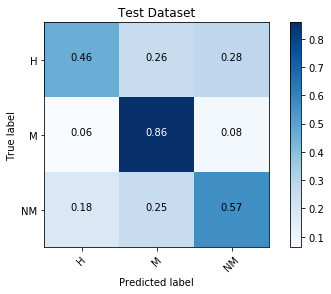

In [148]:
Y_pred = dt_model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(Y_test, Y_pred, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

##### Random Forest

In [149]:
# Find optimal max depth and criterion parameter
param_grid = {'max_depth': np.linspace(5,40,15), 'criterion': ['gini', 'entropy']}
rfc = RFC(random_state=123, n_jobs=-1, n_estimators=50)
rfc_model = GridSearchCV(rfc, param_grid, scoring=f1_scorer)
rfc_model.fit(X_train_res, Y_train_res)
print (rfc_model.best_params_)

{'criterion': 'gini', 'max_depth': 40.0}


In [150]:
# Cross validate using best parameters
avg_acc = []
for i in range(100,125):
    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=1/3, random_state=i, stratify=Y)
    Y_pred = rfc_model.predict(X_test1)
    avg_acc.append(f1_score(Y_test1, Y_pred, average='weighted'))
print ("F1 Score: {}%".format(np.mean(avg_acc)*100))

F1 Score: 92.26585841823514%


F1 Score:  0.763649324178



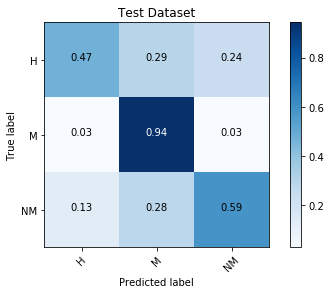

In [151]:
Y_pred = rfc_model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(Y_test, Y_pred, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

##### Artificial Neural Network

In [152]:
# Find optimal hidden layers and activation parameters
param_grid = {'hidden_layer_sizes': [(14), (21), (14,7), (21,14), (14,28,21), (14,21,14)], \
              'activation': ['identity', 'logistic', 'tanh', 'relu']}
mlp = MLPClassifier(random_state=123)
mlp_model = GridSearchCV(mlp, param_grid, scoring=f1_scorer)
mlp_model.fit(X_train_res, Y_train_res)
print (mlp_model.best_params_)

{'activation': 'tanh', 'hidden_layer_sizes': (21, 14)}


In [153]:
# Cross validate using best parameters
avg_acc = []
for i in range(100,125):
    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=1/3, random_state=i, stratify=Y)
    Y_pred = mlp_model.predict(X_test1)
    avg_acc.append(f1_score(Y_test1, Y_pred, average='weighted'))
print ("F1 Score: {}%".format(np.mean(avg_acc)*100))

F1 Score: 77.47242672237502%


F1 Score:  0.737764171694



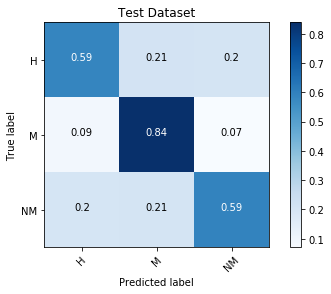

In [154]:
Y_pred = mlp_model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(Y_test, Y_pred, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

##### Gradient Boosting

In [155]:
# Find optimal max depth parameter
param_grid = {'max_depth': np.linspace(5,30,15)}
gbc = GBC(random_state=123, n_estimators=10)
gbc_model = GridSearchCV(gbc, param_grid, scoring=f1_scorer)
gbc_model.fit(X_train_res, Y_train_res)
print (gbc_model.best_params_)

{'max_depth': 17.5}


In [156]:
# Cross validate using best parameters
avg_acc = []
for i in range(100,125):
    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=1/3, random_state=i, stratify=Y)
    Y_pred = gbc_model.predict(X_test1)
    avg_acc.append(f1_score(Y_test1, Y_pred, average='weighted'))
print ("F1 Score: {}%".format(np.mean(avg_acc)*100))

F1 Score: 88.26731804354117%


F1 Score:  0.735241035026



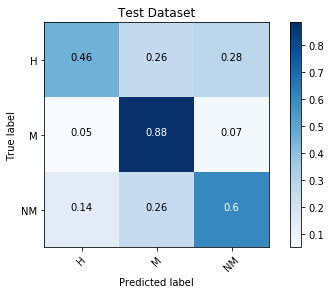

In [157]:
Y_pred = gbc_model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(Y_test, Y_pred, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

##### Support Vector Machine

In [158]:
# Find optimal max depth parameter
param_grid = {'C': [.01, .1, 1, 10, 100], 'gamma': [.01, .1, 1, 10]}
svc = SVC(random_state=123)
svc_model = GridSearchCV(svc, param_grid, scoring=f1_scorer)
svc_model.fit(X_train_res, Y_train_res)
print (svc_model.best_params_)

{'C': 10, 'gamma': 1}


In [159]:
# Cross validate using best parameters
avg_acc = []
for i in range(100,125):
    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=1/3, random_state=i, stratify=Y)
    Y_pred = svc_model.predict(X_test1)
    avg_acc.append(f1_score(Y_test1, Y_pred, average='weighted'))
print ("F1 Score: {}%".format(np.mean(avg_acc)*100))

F1 Score: 88.22784948034321%


F1 Score:  0.617867462269



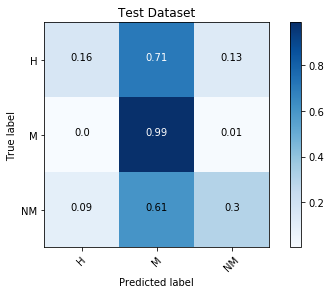

In [160]:
Y_pred = svc_model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(Y_test, Y_pred, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

##### Logistic Regression

In [162]:
# Find optimal max depth parameter
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
mnl = linear_model.LogisticRegression(random_state=123)
mnl_model = GridSearchCV(mnl, param_grid, scoring=f1_scorer)
mnl_model.fit(X_train_res, Y_train_res)
print (mnl_model.best_params_)

{'C': 100, 'penalty': 'l1'}


In [163]:
# Cross validate using best parameters
avg_acc = []
for i in range(100,125):
    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=1/3, random_state=i, stratify=Y)
    Y_pred = mnl_model.predict(X_test1)
    avg_acc.append(f1_score(Y_test1, Y_pred, average='weighted'))
print ("F1 Score: {}%".format(np.mean(avg_acc)*100))

F1 Score: 74.77155019550798%


F1 Score:  0.742201103714



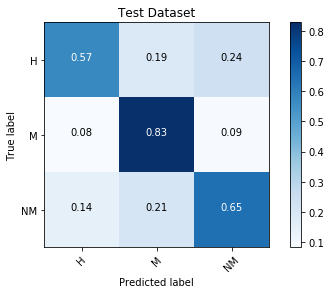

In [164]:
Y_pred = mnl_model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(Y_test, Y_pred, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

#### Compare All Classifiers on Entire Dataset

KeyError: 'dt_model'

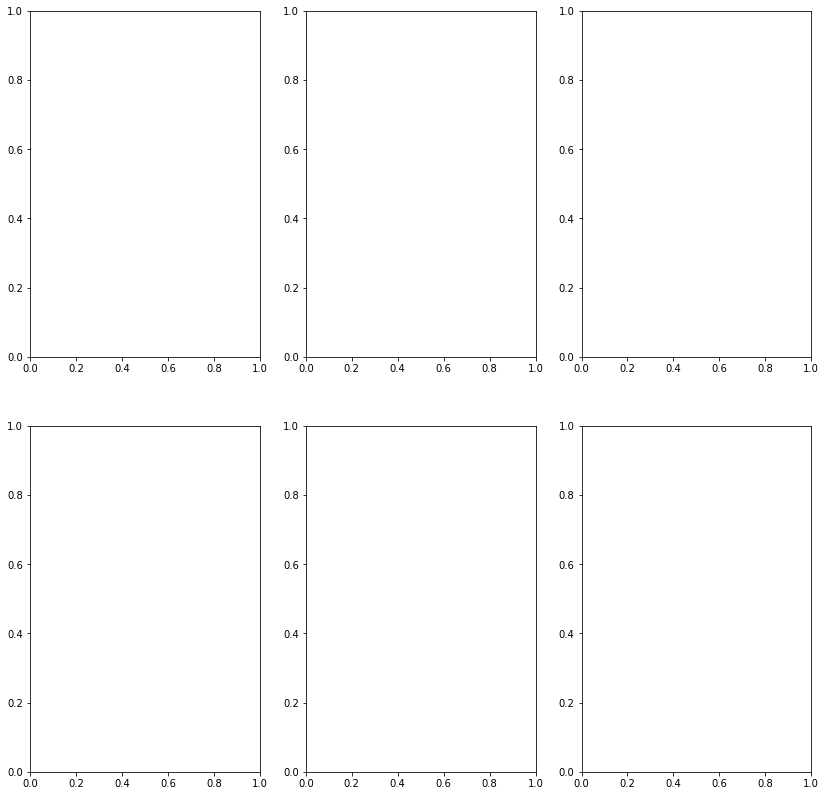

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,14))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
cmap = plt.cm.Blues
classes = ['H', 'M', 'NM']
models = ['dt', 'rfc', 'mlp', 'gbc', 'svc', 'mnl']
axes = [ax0, ax1, ax2, ax3, ax4, ax5]

for model, ax in zip(models, axes):
    Y_pred = globals()['%s_model' % model].predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    np.set_printoptions(precision=2)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(model + ' {0}'.format("F1 Score: {0:.4g}%".format(f1_score(Y_test, Y_pred, average='weighted')*100)))
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

#### Save Model

In [173]:
# Save Classifiers
for model in models:
    joblib.dump(globals()['%s_model' % model], 'processed_data/{}_model.pkl'.format(model))

#### Load Model

In [22]:
# Load Classifiers 
models = ['dt', 'rfc', 'mlp', 'gbc', 'svc', 'mnl']
for model in models:
    globals()['%s_model' % model] = joblib.load('processed_data/{}_model.pkl'.format(model))

#### Predict Probabilities For Each Record

In [23]:
X_train_res.head()

,AGE,ACCESSIBILITY,DIST,Retiree_NM,Retiree_M,Retiree_H,FT_Worker_NM,FT_Worker_M,FT_Worker_H,PT_Worker_NM,PT_Worker_M,PT_Worker_H,DA_Stud_NM,DA_Stud_M,DA_Stud_H,PreSch_Child_NM,PreSch_Child_M,PreSch_Child_H,PDA_Stud_NM,PDA_Stud_M,PDA_Stud_H,Non_Worker_NM,Non_Worker_M,Non_Worker_H,Univ_Stud_NM,...,CAR_SUFF_Fewer Cars than Workers,CAR_SUFF_More Cars than Workers,CAR_SUFF_Zero Cars,"HINCCAT1_$49,999 or less","HINCCAT1_$50,000 to $74,999","HINCCAT1_$75,000 or more",HINCCAT1_DK/RF,EDUCA_Bachelors or Higher Degree,EDUCA_DK/RF,EDUCA_Less than Bachelors,JOBS_DK/RF,JOBS_More than One Job,JOBS_No Job,JOBS_One Job,JOBTYPE_Agriculture and Mining,JOBTYPE_Education,JOBTYPE_Finance & Real Estate,JOBTYPE_Health,"JOBTYPE_Information, Professor/Scientist, Management, Admin",JOBTYPE_MORPC INDUS=80,JOBTYPE_Manufacturing and Wholesale Trade,JOBTYPE_No Job Type,JOBTYPE_Public Admin,JOBTYPE_Retail,"JOBTYPE_Transportation, Utilities and Warehousing"
0,42.0,12.243009,10.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19.0,13.322936,6.56,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5.0,13.529260,5.16,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.0,12.770386,0.00,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,27.0,13.616191,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
idap_processed = features.copy()
probabilities = rfc_model.predict_proba(X)
idap_processed['H'] = [i[0] for i in probabilities]
idap_processed['M'] = [i[1] for i in probabilities]
idap_processed['NM'] = [i[2] for i in probabilities]

predictions = rfc_model.predict(X)
idap_processed['PREDICTION'] = predictions

In [25]:
idap_processed.sort_index(inplace=True)
idap_processed.rename(columns={'SAMPN_x': 'SAMPN', 'PERNO_x': 'PERNO'}, inplace=True)
idap_processed.set_index(['SAMPN'], inplace=True)

F1 Score:  0.92287209606



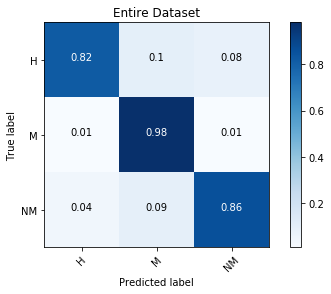

In [26]:
cnf_matrix = confusion_matrix(idap_processed['IDAP'], idap_processed['PREDICTION'])
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(idap_processed['IDAP'], idap_processed['PREDICTION'], average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Entire Dataset')

In [162]:
test1 = [.45,.25,.30]
test2 = [.11,.79,.11]
test3 = [.22, .30, .48]

In [163]:
test = pd.DataFrame(pd.DataFrame(test1).T)
test = test.append(pd.DataFrame(test2).T)
test = test.append(pd.DataFrame(test3).T)

In [168]:
cnf_matrix = np.array(test)

In [169]:
cnf_matrix

array([[ 0.45,  0.25,  0.3 ],
       [ 0.11,  0.79,  0.11],
       [ 0.22,  0.3 ,  0.48]])

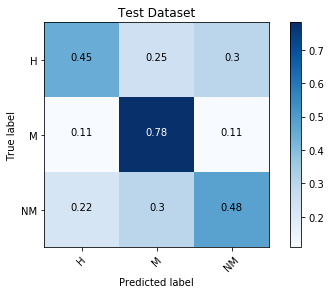

In [171]:
classes = ['H', 'M', 'NM']
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

In [191]:
# Output processed IDAP data to csv
idap_processed.to_csv('processed_data/IDAP_processed.csv')

In [28]:
# Find most important features
rfc =  RFC(random_state=123, n_jobs=-1, n_estimators=50, max_depth=40, criterion='gini')
rfc_model = rfc.fit(X_train_res, Y_train_res)
values = sorted(zip(X_train_res.columns, rfc_model.feature_importances_), key=lambda x: x[1] * -1)
feature_importance = pd.DataFrame(values)
feature_importance.columns = ["name", "score"]
feature_importance.set_index('name', inplace=True)
feature_importance

,score
name,
AGE,0.096858
DIST,0.090130
ACCESSIBILITY,0.084902
PreSch_Child_H,0.040832
FT_Worker_H,0.033422
FT_Worker_M,0.032258
PDA_Stud_M,0.031394
PERTYPE_FT_Worker,0.028287
Non_Worker_H,0.026714


In [29]:
feature_importance.to_csv('random_forest_feature_importance.csv')

In [132]:
# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, stratify=Y, random_state=16)

In [133]:
# Upsample to balance out classes
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)

In [134]:
dtc =  DTC(random_state=123, max_leaf_nodes=15)
dt_model = dtc.fit(X_train_res, Y_train_res)

In [135]:
with open("processed_data/dt_model.txt", "w") as f:
    f = tree.export_graphviz(dt_model, out_file=f)

In [131]:
for i in range(1,100):
    # Split data into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, stratify=Y, random_state=i)
    # Upsample to balance out classes
    sm = SMOTE(random_state=12, ratio = 1.0)
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    dtc =  DTC(random_state=123, max_leaf_nodes=13)
    dt_model = dtc.fit(X_train_res, Y_train_res)
    with open("processed_data/dt_model.txt", "w") as f:
        f = tree.export_graphviz(dt_model, out_file=f)
    if 'X[0]' in open("processed_data/dt_model.txt").read():
        print (i)

16
70
90


In [98]:
pd.DataFrame(X_train_res.columns)

,0
0,AGE
1,ACCESSIBILITY
2,DIST
3,Retiree_NM
4,Retiree_M
5,Retiree_H
6,FT_Worker_NM
7,FT_Worker_M
8,FT_Worker_H
9,PT_Worker_NM
